<a href="https://colab.research.google.com/github/pgurazada/understanding-self-attention/blob/main/understanding_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Self Attention Overview</center></font></h1>
<h1><center>Implementation of Self Attention</center></h1>
<h3><center>Charlcye Mitchell, April 2024</center></h3>

Proprietary content. ©Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited

# Objective

- Introduce the key idea of self-attention that is at the heart of GPT-style models
- Understand the computation mechanism of self-attention by transformer models
- Implement the self-attention computation in Python

Note: In this notebook, we will load the Mistral model and inspect its architecture. We will rely on the T4 GPU provided by Google Colab for this exercise. The rest of the notebook does not need a GPU for execution.

# Setup

In [ ]:
!pip install -q bitsandbytes==0.42.0 \
                transformers==4.35.2 \
                accelerate==0.26.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 33.8 MB/s eta 0:00:00


In [ ]:
import math
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

# Introduction

How do humans store and express knowledge? One method is to use language. We use about 2,000 words in our active vocabulary (i.e., in everyday parlance) but the overall vocabulary of an average adult is about 30,000 words. Researchers have proposed that we acquire this vocabulary through reading, and that the bulk of knowledge acquition happens as we ingest and learn from the texts we read.

This idea was tested out at scale first by researchers at Google who came up with a unique architecture (called the *Transformer*) that was able to ingest large amounts of text in one batch and synthesize this text into a numeric representation. What is particularly interesting is that Open AI then deployed this compute efficient architecture to solve a delightfully simple problem called *language modeling* (see figure below): given an input text of certain fixed length, can we predict the next word that completes this input text? Neither was language modeling objective novel nor was the model architecture. The genius was in using the architecture to achieve the language modeling objective.

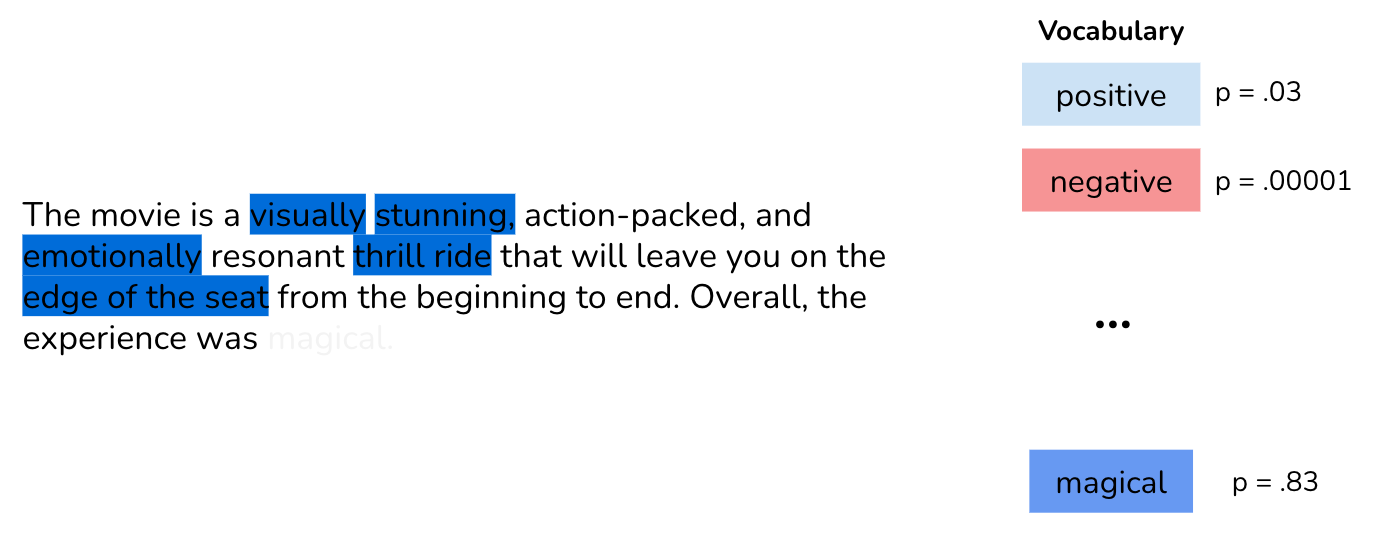


This series of experiments kicked off the GPT-series ane eventually to the GPT-3.5 model that captured the imagination of millions of users through its intuitive interface - ChatGPT. Open AI popularized the idea of *pretraining* where a numeric representation of sentences is learned by processing very large amounts of text using a transformer architecture.

In this notebook, we take a close look at the central workhorse of GPT-style models: the concept of self-attention.

# The architecture of GPT-style models

## Transformers

The original transformer architecture (see figure below) was proposed for language translation in 2017 by researchers at Google.

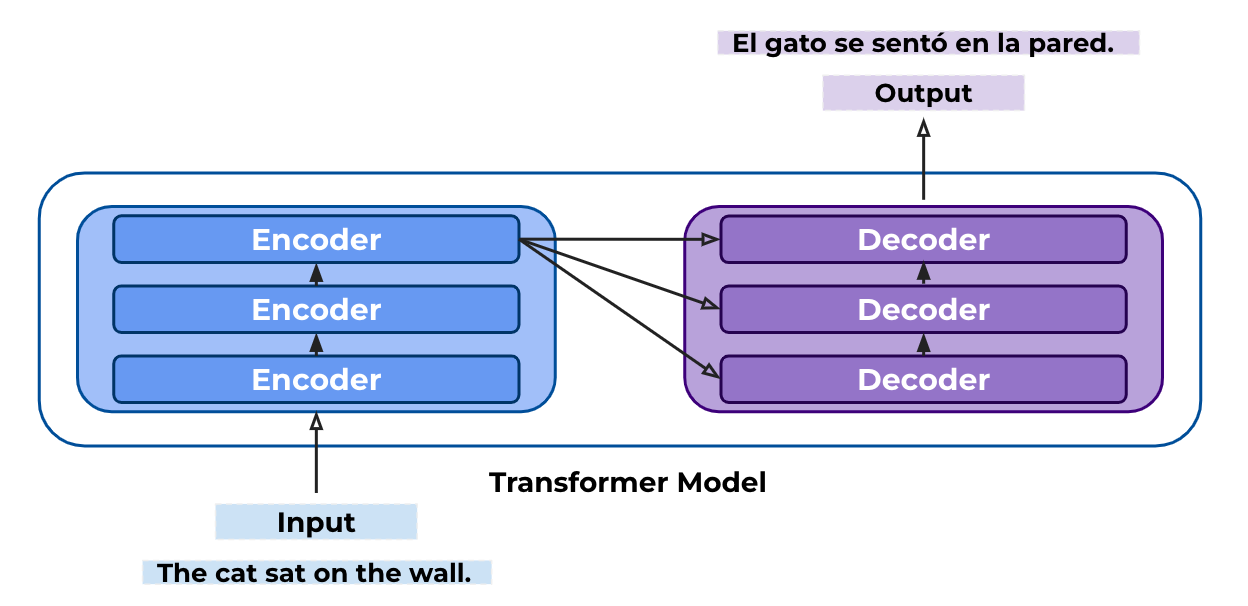

As the above figure indicates, the transformer ingests the input sentence in one go and encodes a numeric representation of this input using a series of encoder blocks. This numeric representation is then passed over to a series of decoder blocks that *generate* a translated output word-by-word.

The unique aspect of this architecture is the way the encoding and the decoding work. During encoding, all the words in the input sentence are processed at once. However, while decoding, the model is only allowed to look at the words that is has already predicted to make a new prediction. That is, the decoder blocks can only look at the history.

This aspect of decoder blocks is what makes them valuable from a generation perspective. They can look at a piece of text in its current state and predict what is an ideal word that can be appended to this text.

In sum, transformers can be thought of a mapping from an input sequence (say, a sentence in English) to an output sequence (say, the translation to French).

## GPT-style transformers

GPT-style transformers popularized by Open AI and the current generative AI revolution use only the decoder portion of the original transformer architecture during training and inference.

Let us begin our dissection of GPT-style transformer architectures by taking a look at the internals of a powerful modern LLM - Mistral 7b. To be able to inspect this model, we will need to load it on to the Colab GPU RAM.

Mistral 7b has 7 billion parameters that occupies $7 \text{ billion} \times 2 \text{ bytes} = 14 \text{ GB}$ on disk (each parameter in 16-bit floating point precision occupies 2 bytes). In order to be able to load this model on a Colab GPU (with 15 GB GPU RAM), we will need to lower the floating point precision of the original model (referred to as quantization). In this notebook, we load the Mistral 7b model in 4-bit precision using the `BitsAndBytes` package.

In [ ]:
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype='float16',
    bnb_4bit_use_double_quant=False
)

In [ ]:
mistral7b_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Now that the model is loaded on the GPU, we can inspect the model architecture like so (to reiterate, we reduce precision so that the model fits on the T4 GPU; training happens in full precision).

In [ ]:
mistral7b_model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

As the above output indicates, at the heart of the model is a set of 32 MistralDecoder layers. And within each decoder layer is a key component: the self-attention layer. We will dive deep into the internals of these layers shortly.

To begin with, let us understand how Mistral processes input text (i.e., the prompt) and *generates* the output, that is, let us run one inference step.

As an example, consider the following batch of two sentences that we seek completions for. Imagine that this is a set of two prompts presented to the model and it has to generate the ideal word that is most likely to occur after the prompt.

In [ ]:
text_batch = [
    "formal algorithms for transformers",
    "normal algorithms for transformers"
]

We will present these two sentences to Mistral and observe the output as they traverse through the 32 Decoder layers and then collect the output for this batch of 2 sentences.

To do so we first need to tokenize these sentences. In other words, break the sentences into individual words and attach a numeric identifier to each word in the sentence.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    max_length=6,
    padding_side="left"
)

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Sentences in a batch could be of varying lengths. Hence, we will need to pad uneven sentences to be of a certain fixed length.

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
inputs = tokenizer(
    text_batch,
    max_length=6,
    padding='max_length',
    return_tensors='pt'
)

In [ ]:
inputs

{'input_ids': tensor([[    1,  9907, 18539,   354,  5516,   404],
        [    1,  4123, 18539,   354,  5516,   404]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])}

In [ ]:
key = 'input_ids'
print(f"{key} shape: {inputs[key].shape}")

input_ids shape: torch.Size([2, 6])


Let us now push this input batch of sentences through the model and collect the outputs.

In [ ]:
outputs = mistral7b_model(**inputs)

In [ ]:
outputs.logits.shape

torch.Size([2, 6, 32000])

The outputs have logits that have a dimension of $(2, 6, 32000)$. This means that the two sentences each with 6 words (including padding), are mapped to 6 sequences of 32,000 probabilities. These probabilities correspond to the 32,000 words in Mistral's vocabulary. To make a prediction, we can pick the word that is assigned the maximum probability. Note that even though we are interested only in the last logit for each sentence, we still get predictions for all the subsets in the input sequence.

Why do we get 6 probability vectors even though we need one probability vector, that corresponds to the prediction for the next-word? To understand this, we will need to go deeper into how LLMs like Mistral contextualize inputs using *self-attention*.

# Self-Attention

An important innovation of the transformer architecture was *self-attention* that allows the network to extract and use information from an arbitrarily large context window (as allowed by the compute infrastructure). The self-attention mechanism maps a tuple of input sequences $(\mathbf{q_1}, \mathbf{q_2}, \ldots, \mathbf{q_n})$ to a tuple of output sequences $(\mathbf{v_1}, \mathbf{v_2}, \ldots, \mathbf{v_n})$. Note that both the input and output are of the same length. Each word in the input sequence is associated with a vector of length $d_{in}$ that is then modified into a contextualized input sequence. After self-attention is applied, each word in the output sequence is then associated with a vector of length $d_{out}$.

Through self-attention, each word in the sequence becomes aware of the other words in the sequence. We will look at how exactly this "contextualization" is formalized shortly.



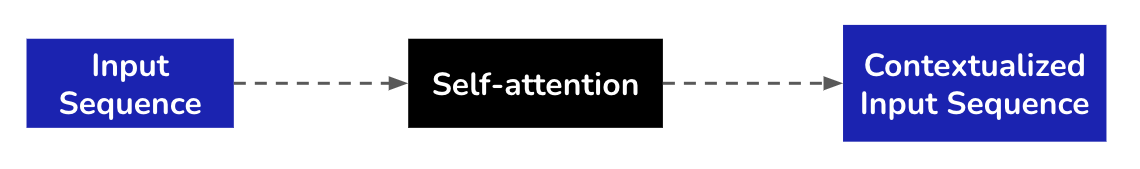

Note that we restrict sequences to a fixed length of $n$ that is referred to as context length. If inputs are lesser than the context length, they are padded. If the inputs are larger than the context length, they are chopped.   

## Arranging data for self-attention

The first step in formalization of the computation of contextual representations using self-attention is to understand how training data is prepared to learn these representations. For example, consider the sequences we ran inference earlier on:

Sequence 1: `<s> formal algorithms for transformers <\s>`

Sequence 2: `<s> normal algorithms for transformers <\s>`

During training (and hence during inference), this is batch of 2 sequences is converted to multiple sequences like so.

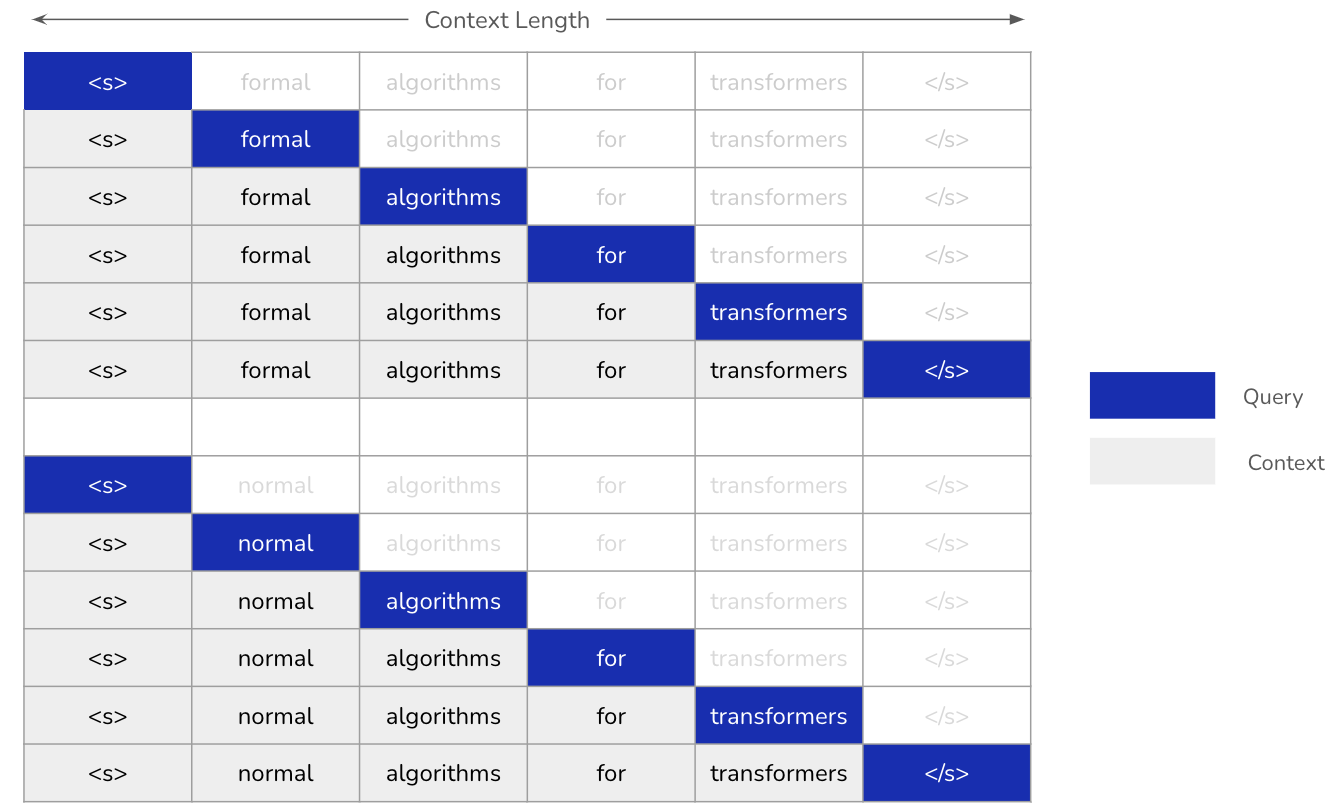

Notice how we create 6 (= context length) copies of each sentence and in each copy one of the words acts as the query, that is, the word we are trying to contextualize. We do so by allowing this query to interact with the context words. In a sense, this replication parallelizes the interaction of the context words with the query words.

However, at any point, we are not allowed to look at the future words. Note that the 6 copies are not strictly independent of each other, but we treat them as if they were. This method allows us to convert large amounts of unlabeled data into pairs of context - query, hence bringing the problem of next word prediction to a supervised learning realm.


While this method of arranging data allows us to scale training massively, it still leaves two problems unanswered:
1. How do we predict the query word accounting for all the context words before it? In other words, what specific method do we use to contextualize the query given the context?
2. How do we ensure that our computational mechanism forbids queries looking at future words (given that they exist in the copies)?

Let us look at how self-attention solves for these two problems using a single context - query prediction. Extending self-attention to batches of sequences is a direct extension of our discussion of single-query attention.

## What is (single-query) self-attention?

Attention tackles the problem of contextualizing a specific query within the context of the other words in the input sequence. In self-attention the query is contextualized using the other words in the same sequence. As the figure above indicates, during training words in the input take turns to play the role of a query in the duplicated samples and the rest of the words play the role of context words.

But how does this contextualization translate to mathematically?

In the sentence: 'formal algorithms for transformers', consider a query word (say 'algorithms') represented by the vector $\mathbf{q}$  and the context word (say 'formal') represented by the vector $\mathbf{k}$. If the word 'formal' is close to 'algorithms' semantically, then the vectors $\mathbf{q}$ and $\mathbf{k}$ would be close to each other. One way to mathematically express this similarity is to use the dot product $\mathbf{q}\mathbf{k}^T$.

Let us consider this as the score associated with the query-context word pair:

$$
\text{score}(\mathbf{q}, \mathbf{k}) = \mathbf{q}\mathbf{k}^T
$$

We can roll out this computation for all the context words in the input and compute a weight ($\alpha_c$) attached to this specific context word ('for') using a softmax like so:
$$
\alpha_{c} = \text{softmax}(\text{score}(\mathbf{q}, \mathbf{k}))
= \dfrac{\text{exp}(\text{score}(\mathbf{q}, \mathbf{k}))}{\sum\text{exp}(\text{score}(\mathbf{q}, \mathbf{k}))}
$$

Here, $\alpha_c$ refers to the weightage associated to the context word (in this case, 'for') normalized using all the other context word scores. We will call these *attention weights* since they capture the relative importance (or attention) that the query needs to pay to each word in the context.

As a last step, we will need to embed this computation into a learnable mechanism that will push semantically close words closer to each other during training for last word prediction. We achieve this using the query-key-value formulation like so:

- A word (represented by a $d_{in}$ dimension vector $\mathbf{x}$) that we are currently focusing on (e.g., 'algorithms') is called the *query* and is associated a vector $\mathbf{q} = \mathbf{W_q} \mathbf{x} + \mathbf{b_q}$. Here $\mathbf{W_q}$ is of dimension $d_{attn} \times d_{in}$. This ensures that the input query $\mathbf{x}$ is pushed to an attention space with dimension $d_{attn}$. For example, Mistral and Llama2 have $d_{attn} = 4096$.
- All the preceding context words (e.g., 'formal') are referred to as *keys* (represented by a $d_{in}$ dimension vector $\mathbf{x'}$) and are associated with vectors $\mathbf{k_c} = \mathbf{W_k} \mathbf{x'} + \mathbf{b_k}$. Here $\mathbf{W_k}$ is of dimension $d_{attn} \times d_{in}$. This ensures that keys in the context are also pushed to an attention space with dimension $d_{attn}$.
- With queries and keys in a (learnable) attention space, we can collect the attentions weights for each of the keys as: $\alpha_c = \text{softmax}(\text{score}(\mathbf{q}, \mathbf{k_c}))$. Note that $\alpha_c$'s are scalars.
- As the final step of the contextualization, each key vector is projected into an output space as a *value* vector $\mathbf{v_c} = \mathbf{W_v} \mathbf{x'} + \mathbf{b_v}$, where $\mathbf{W_v}$ is of dimension $d_{out} \times d_{in}$. Now, for the input query $\mathbf{q}$ we return its contextualized representation as the vector $\mathbf{\tilde{v}} = \sum \alpha_c\mathbf{v_c}$.

The contextualization is complete since each of the context words has a say in the representation of the query (just like a weighted average).

During the training process, we learn the following weight matrices:
- $\mathbf{W_q}$ of dimension $d_{in} \times d_{attn}$
- $\mathbf{W_k}$ of dimension $d_{in} \times d_{attn}$
- $\mathbf{W_v}$ of dimension $d_{out} \times d_{in}$

These matrices are at the heart of the Mistral architecture we saw earlier:

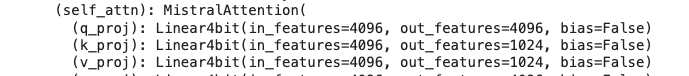

## Implementing self-attention

Notice that there is no sense of position in the attention mechanism we discussed so far. We still have to enforce a computationally efficient mechanism that masks out future context words when a query is attending to the context using this mechanism. This requires a simple masking trick that we will look at as we implement this algorithm using PyTorch.

In [ ]:
class SingleQuerySelfAttention(torch.nn.Module):

    """
    Contextualize a single input vector by attending over its context
    vectors.

    Args:
        d_in (int): size of query vector and the context vectors in the input sequence
        d_attn (int): dimension of the query-key projection space
        d_out (int): size of contextualized query

    Input:
        x1 (tensor) [d_in]: single token embedding to be contextualized
        z (tensor) [l_z, d_in]: sequence of context token embeddings. Here l_z is the context length
        mask (tensor) [l_z]: attention mask

    Output:
        q (tensor) [d_attn]: query vector for x1
        k (tensor) [l_z, d_attn]: key vectors for z
        v (tensor) [l_z, d_out]: value vectors for z

        score (tensor) [l_z]: score = (q @ k^T) / sqrt(d_attn)
            where mask = 1 else minimum value for score tensor dtype
        attention (tensor) [l_z]: attention weights
            explicitly set to 0 where mask = 0
        vtilde (tensor) [d_out]: contextualized representation of x1

    Attributes:
        w_q (tensor) [d_in, d_attn]: query weight tensor
        w_k (tensor) [d_in, d_attn]: key weight tensor
        w_v (tensor) [d_in, d_out]: value weight tensor

        b_q (tensor) [d_attn]: query bias tensor
        b_k (tensor) [d_attn]: key projection tensor
        b_v (tensor) [d_out]: value projection tensor

    """

    def __init__(
        self,
        d_in: int,
        d_attn: int,
        d_out: int,
    ):

        super().__init__()
        self.d_in = d_in
        self.d_attn = d_attn
        self.d_out = d_out

        self.scale = 1 / math.sqrt(d_attn)

        self.w_q = torch.nn.Parameter(torch.empty(d_in, d_attn))
        self.w_k = torch.nn.Parameter(torch.empty(d_in, d_attn))
        self.w_v = torch.nn.Parameter(torch.empty(d_in, d_out))


        self.b_q = torch.nn.Parameter(torch.empty(d_attn))
        self.b_k = torch.nn.Parameter(torch.empty(d_attn))
        self.b_v = torch.nn.Parameter(torch.empty(d_out))

        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_normal_(self.w_q)
        torch.nn.init.xavier_normal_(self.w_k)
        torch.nn.init.xavier_normal_(self.w_v)

        torch.nn.init.zeros_(self.b_q)
        torch.nn.init.zeros_(self.b_k)
        torch.nn.init.zeros_(self.b_v)

    def forward(
        self,
        x1: torch.Tensor,
        z: torch.Tensor,
        mask: torch.Tensor,
    ):


        q = x1 @ self.w_q + self.b_q
        k = z @ self.w_k + self.b_k
        v = z @ self.w_v + self.b_v


        score = q @ k.T * self.scale
        score = score.masked_fill(~mask.to(torch.bool), -float("Inf"))
        attention = torch.softmax(score, dim=-1)

        vtilde = attention @ v

        return {
            "q": q,
            "k": k,
            "v": v,
            "score": score,
            "attention": attention,
            "vtilde": vtilde,
        }

Let us zoom into the $\mathbf{q}\mathbf{k}^T$ computation above where we apply a mask. Note that the mask is applied in the forward pass and the original $\mathbf{q}\mathbf{k}^T$ scores are replaced with $-\infty$ under the masking condition. Since we have a softmax applied in the next step, this is equivalent to zeroing out the attention scores to the positions where attention should not be paid to. This mechanism is depicted below.

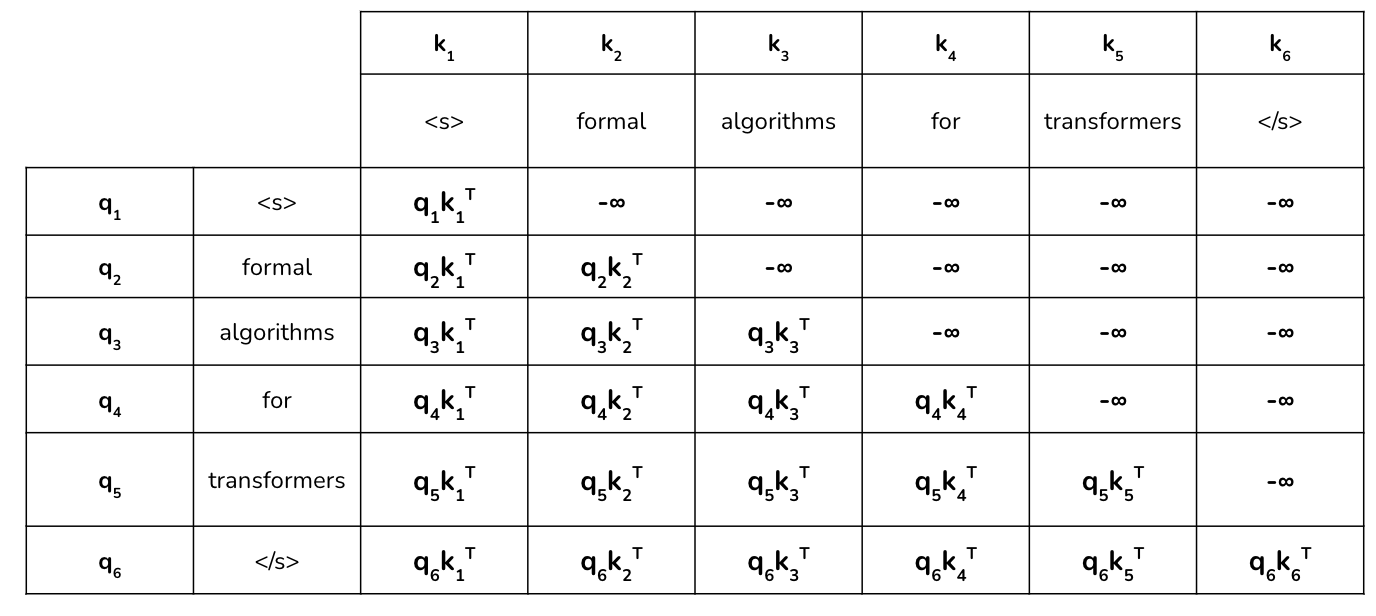

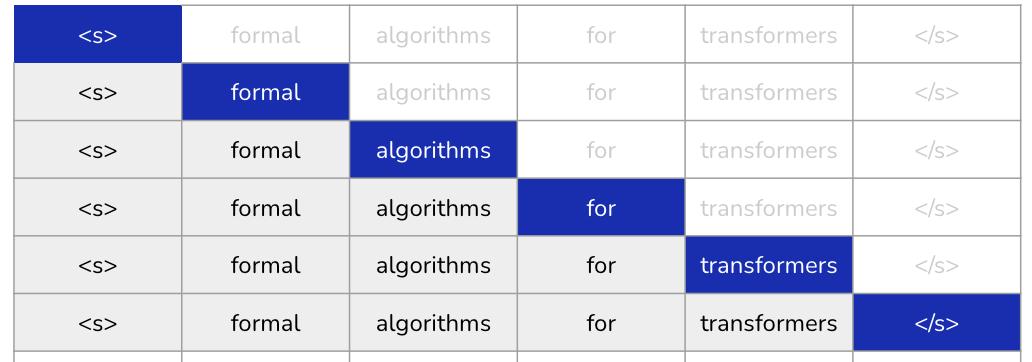

As the above figure depicts, we can use the mask to cleverly zero out contributions from the future. Let us now see how the entire masked self-attention works in action.

In [ ]:
d_in, d_attn, d_out, l_z = 2, 4, 5, 3

In [ ]:
x1 = torch.randn(d_in)

In [ ]:
x1

tensor([0.1576, 0.2608])

In [ ]:
z = torch.rand(l_z, d_in)

In [ ]:
z

tensor([[0.1543, 0.5134],
        [0.1401, 0.1172],
        [0.7566, 0.3534]])

For GPT-style models we do not want the query to pay attention to the tokens after it. This is where the mask comes to play (it has a dimension $l_z$).

In [ ]:
# This mask forces the query to look only at the first key
mask = torch.tensor([1, 0, 0])

In [ ]:
sqsa = SingleQuerySelfAttention(d_in, d_attn, d_out)

In [ ]:
sqsa(x1, z, mask)

{'q': tensor([ 0.0751, -0.0242, -0.0258,  0.0158], grad_fn=<AddBackward0>),
 'k': tensor([[ 0.1143, -0.1717,  0.3013, -0.0957],
         [ 0.0794, -0.0923, -0.0250, -0.1285],
         [ 0.4095, -0.4474, -0.3742, -0.7272]], grad_fn=<AddBackward0>),
 'v': tensor([[ 0.4827,  0.0545, -0.1500,  0.0270, -0.1562],
         [ 0.0874,  0.0246, -0.0447,  0.0054, -0.0735],
         [ 0.1910,  0.1132, -0.1684,  0.0140, -0.3421]], grad_fn=<AddBackward0>),
 'score': tensor([0.0017,   -inf,   -inf], grad_fn=<MaskedFillBackward0>),
 'attention': tensor([1., 0., 0.], grad_fn=<SoftmaxBackward0>),
 'vtilde': tensor([ 0.4827,  0.0545, -0.1500,  0.0270, -0.1562],
        grad_fn=<SqueezeBackward4>)}

Without the mask the query can look at future context words and the attention score gets polluted.

In [ ]:
sqsa(x1, z, mask = torch.tensor([1, 1, 1]))

{'q': tensor([ 0.0751, -0.0242, -0.0258,  0.0158], grad_fn=<AddBackward0>),
 'k': tensor([[ 0.1143, -0.1717,  0.3013, -0.0957],
         [ 0.0794, -0.0923, -0.0250, -0.1285],
         [ 0.4095, -0.4474, -0.3742, -0.7272]], grad_fn=<AddBackward0>),
 'v': tensor([[ 0.4827,  0.0545, -0.1500,  0.0270, -0.1562],
         [ 0.0874,  0.0246, -0.0447,  0.0054, -0.0735],
         [ 0.1910,  0.1132, -0.1684,  0.0140, -0.3421]], grad_fn=<AddBackward0>),
 'score': tensor([0.0017, 0.0034, 0.0199], grad_fn=<MaskedFillBackward0>),
 'attention': tensor([0.3311, 0.3317, 0.3372], grad_fn=<SoftmaxBackward0>),
 'vtilde': tensor([ 0.2532,  0.0644, -0.1213,  0.0155, -0.1915],
        grad_fn=<SqueezeBackward4>)}

In [ ]:
# This mask forces the query to look only at the first two keys
mask = torch.tensor([1, 1, 0])

In [ ]:
sqsa = SingleQuerySelfAttention(d_in, d_attn, d_out)

In [ ]:
sqsa(x1, z, mask)

{'q': tensor([-0.0475, -0.3317, -0.0467,  0.1266], grad_fn=<AddBackward0>),
 'k': tensor([[-0.3886, -0.3592,  0.2852,  0.0774],
         [-0.2070, -0.0573,  0.0986,  0.0662],
         [-1.0016, -0.0940,  0.4043,  0.3541]], grad_fn=<AddBackward0>),
 'v': tensor([[ 0.3821,  0.2247, -0.0178, -0.0319, -0.0419],
         [ 0.0806,  0.1098, -0.0298, -0.0121, -0.0400],
         [ 0.2218,  0.5176, -0.1716, -0.0520, -0.2175]], grad_fn=<AddBackward0>),
 'score': tensor([0.0671, 0.0163,   -inf], grad_fn=<MaskedFillBackward0>),
 'attention': tensor([0.5127, 0.4873, 0.0000], grad_fn=<SoftmaxBackward0>),
 'vtilde': tensor([ 0.2351,  0.1687, -0.0236, -0.0223, -0.0410],
        grad_fn=<SqueezeBackward4>)}

In [ ]:
out = sqsa(x1, z, mask)

In [ ]:
out['attention']

tensor([0.5127, 0.4873, 0.0000], grad_fn=<SoftmaxBackward0>)

In [ ]:
x1.shape

torch.Size([2])

In [ ]:
out['vtilde'].shape

torch.Size([5])

The query word that was an "out-of-context" 2-dimensional vector and gets "contextualized" as a 5-dimensional vector as it goes through a 4-dimensional attention space.